In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# !pip install nltk
# !pip install seqeval
# !pip install ipywidgets

In [3]:
import nltk
import seqeval
from seqeval.metrics import classification_report, f1_score

## Named Entity Recognition (NER)

[NER](https://en.wikipedia.org/wiki/Named-entity_recognition) is a Natural Language Processing (NLP) task that consists in 
  identifying and classifying names of entities (people, location, companies, among others) in a given sentence.
For instance, given the following sentence:

```
Jim bought 300 shares of Acme Corp. in 2006.
```

a NER system should identify and classify the three named entities as in the following:

<font color='blue'>[Jim]<sub>Person</sub></font> bought 
300 shares of 
<font color='red'>[Acme Corp.]<sub>Organization</sub></font> in 
<font color='green'>[2006]<sub>Time</sub></font>.




### IOB Tagging Format
In order to cast NER as a sequence tagging problem, we usually make use of the [IOB Tagging Scheme](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).
In this scheme, one *IOB tag* is attributed to each token (a token is a word or a puctuation mark) in the input sentence.

Jim | bought | 300 | shares | of | Acme | Corp. | in | 2006 | .
---|---|---|---|---|---|---|---|---|---
`I-PER` | `O` | `O` | `O` | `O` | `I-ORG` | `I-ORG` | `O` | `I-TIME` | `O`

As you can see, each tag identifies the type of the corresponding entity.
The tags `I-<type>` indicates that a token is *inside* an entity of type `<type>`.
Additionally, there is the *out* tag `O` indicating that the token is not part of any entity.
Usually, consecutive tokens classified with the same type are considered part of the same entity.
When there are two consecutive tokens that are part of two different entities but of the same type, we need to use a *begin* tag `B-<type>`. There is one `B-<type>` tag for each entity type.
Such tags indicate the first token of an entity
  when the previous token is part of another entity of the same type.
See the [Wikipedia article](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) for more details.


### CoNLL-2003 Dataset

The CoNLL-2003 dataset is one of the most used datasets for NER.
In the following, we show a snnipet of this dataset.

```
-DOCSTART- -X- -X- O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O
. . O O

Peter NNP I-NP I-PER
Blackburn NNP I-NP I-PER

(...)

-DOCSTART- -X- -X- O

Rare NNP I-NP O
Hendrix NNP I-NP I-PER
song NN I-NP O

(...)

```

Each line contains a token.
An empty line is used to separate sentences.
A line containing `-DOCSTART- -X- -X- O` is used to separate documents (for NER, usually, we disregard these document boundaries).
Each token contains four features separated by space:
```
word pos_tag chunk_tag ner_tag
```
The first feature `word` contains the string of the token (word or punctuation mark).
The second feature `pos_tag` indicates the part-of-speech of the token.
The third feature `chunk_tag` encodes chunking information (phrases).
And, finally, the last feature `ner_tag` comprises the NER annotations using IOB tagging scheme.

### Training and Evaluation Data
The CoNLL-2003 dataset is split into three parts: train, testa and testb.
The `train` split is obviously used to model training and the remaining two splits are used for model selection and testing.
We will use the `testa` split to evaluate our models.

In [4]:
# # download train and dev files
# !wget https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.train
# !wget https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.testa

## Encoder

Define a simple class to encode symbols 
  (tags and observation features) as integers (IDs).
Basically, we use two entangled data structures: 
  a dictionary (symbol -> ID) 
  and a list (Id -> symbol).

Then, we can represent the CRF parameters as arrays and matrices indexed by integers (IDs) instead of strings.
But, at the same time, we can keep the mapping between symbol name (string) and its ID (integer).

In [5]:
class Encoder:
    """Encode a set of N symbols (strings) into integer IDs from {0, 1, ..., N-1}

    The encoder can be frozen at some point and then no new symbol can be added.
    When a frozen encoder gets a request for an unknown symbol, it raises an 
    exception.
    """
    
    def __init__(self, symbols: list = None, frozen: bool = False):
        """Create a new encoder with optional list of symbols.

        Args:
            symbols (list[str]): list of symbols (default is None)
            frozen (bool): whether the encoder includes new symbols passed to method `get_id(s)` (default is False)
        """
        self.symbol_to_id: dict[str, int] = {}
        self.id_to_symbol: list[str] = []
        self.frozen: bool = False
        
        if symbols is not None:
            for s in symbols:
                self.get_id(s)
        
        if frozen:
            self.frozen = True
    
    def get_id(self, s: str) -> int:
        """return the ID (integer) corresponding to symbols `s`.

        If symbols `s` has not been encoded already and `self.frozen == False`,
        then include `s` in the mapping, assign a new ID for it, and return it.
        If symbols `s` has not been encoded already and `self.frozen == True`,
        raise an exception.

        Args:
            s (str): symbol to be encoded

        Returns:
            int: ID of the encoded symbol
        """
        if s not in self.symbol_to_id:
            if self.frozen:
                raise ValueError(f'Symbol {s} not in frozen encoder {self}')
            
            new_id = len(self.id_to_symbol)
            self.symbol_to_id[s] = new_id
            self.id_to_symbol.append(s)
            return new_id
        
        return self.symbol_to_id[s]
    
    def get_symbol(self, id: int) -> str:
        """return the symbols associated with `id`

        Args:
            id (int): ID of the symbol
        
        Returns:
            str: the symbol associated with the given ID
        """
        return self.id_to_symbol[id]
    
    def __repr__(self):
        return f'Encoder: {self.symbol_to_id}'
    
    def __len__(self):
        return len(self.id_to_symbol)

In [6]:
# we use one encoder for all observation features
x_enc = Encoder()
# encoder for tags
y_enc = Encoder()

## Encode a Sentence
When working with an HMM, 
  we created a function to encode a token 
  because this model can only deal with one observation per token.
However, now that we are going to work with a CRF model, 
  for a given token $x_t$, 
  we can define observation features 
  $\boldsymbol\phi^{obs}(x, y_t)=(\phi^{obs}_1(x, y_t), \ldots, \phi^{obs}_{d_{obs}}(x, y_t))$ 
  that are, in fact, based on the whole sentence 
  $x=(x_1,\ldots,x_T)$ and not only on $x_t$.
So we implement below a function that encode a whole sentence.

The given sentence is a sequence of tokens
  and each token comprises 
  the word,
  the POS tag,
  the chunking tag,
  and the NER tag 
  (as given in the CoNLL corpus).
The NER tag is the target variable $y_t$.
The remaining information pieces can be used to generate observation features.

In [7]:
def encode_sentence(sentence):
    """Encode a sentence composed of token features and NER tags into integer features.

    Args:
        sentence (list[tuple[str, str, str, str]]): list of tokens with features.
            Each token must be a tuple `(word, pos, ck, ner)`, where `word` is 
            the word, `pos` is the POS tag of the token, `ck` is the chunking 
            tag, and `ner` is the NER tag. This tuple comes from the CoNLL corpus.
    Returns:
        tuple[list[list[int]], list[int]]: two lists containing the encoded 
        features and NER tags for each token. Each token comprises a list of 
        encoded features.
    """
    x = []
    y = []
    for t in range(len(sentence)):
        # each token must comprise four features: word, pos, ck, ner
        word, pos, ck, ner = sentence[t]
        if t >= 1:
            prev_word, prev_pos, prev_ck, prev_ner = sentence[t-1]
        else:
            prev_word, prev_pos, prev_ck, prev_ner = "PAD", "PAD", "PAD", "PAD"

        # we can derive any features from the whole input sentence to represent
        # the t-th token
        token_ftrs = \
            [
             f'word={word.lower()}',
             f'word={word.lower()}_AND_prev_word={prev_word.lower()}',
            #  f'is_first_letter_upper_{word[0].isupper()}', 
            #  f'POS={pos}'
            # TODO think about other features and try different combinations
            ]

        # encode the features and store them
        x.append([x_enc.get_id(ftr) for ftr in token_ftrs])
        # encode tag
        y.append(y_enc.get_id(ner))
    
    return x, y

The function below iterate over a CoNLL file (train or evaluation), 
  encode each word and its NER tag, 
  and return two lists: `xs` and `ys`.
Each element in `xs` comprises a sentence of the dataset 
  (list of features for each token).
And each element in `ys` comprises the corresponding sequence of tags.

In [8]:
def load_examples(file):
    xs = []
    ys = []
    with open(file) as f:
        sentence = []
        for line in f:
            if len(line.strip()) == 0:
                # a blank line separates sentences
                if len(sentence) > 0:
                    # end of a sentence
                    x, y = encode_sentence(sentence)
                    xs.append(x)
                    ys.append(y)
                    sentence = []
            elif line.startswith('-DOCSTART-'):
                # start of a new document (ignore document boundaries)
                pass
            else:
                # a token contains four fields (separated by space):
                # word, POS tag, noun-phrase tag, and NER tag
                sentence.append(line.split())
    
    return xs, ys

Load traind and evaluation (dev) datasets.

In [10]:
x_train, y_train = load_examples('eng.train')
x_dev, y_dev = load_examples('eng.testa')

Freeze the encoders to avoid bugs.

In [11]:
x_enc.frozen = True
y_enc.frozen = True

Number of sentences in each dataset.

In [12]:
print(f'# train exs: {len(x_train)}')
print(f'# dev exs: {len(x_dev)}')

# train exs: 14041
# dev exs: 3250


Number of unique words in the datasets.

In [13]:
print(f'# unique x: {len(x_enc)}')

# unique x: 147543


Number of tags.

In [14]:
print(f'# unique y: {len(y_enc)}')

# unique y: 8


Visualize the tags and their corresponding IDs.

In [15]:
y_enc

Encoder: {'I-ORG': 0, 'O': 1, 'I-MISC': 2, 'I-PER': 3, 'I-LOC': 4, 'B-LOC': 5, 'B-MISC': 6, 'B-ORG': 7}

In [34]:
len(x_enc)

147543

In [35]:
x_enc.get_symbol(0), x_enc.get_symbol(1), x_enc.get_symbol(2), x_enc.get_symbol(3), 

('word=eu',
 'word=eu_AND_prev_word=pad',
 'word=rejects',
 'word=rejects_AND_prev_word=eu')

Distribution of the tags.
We can already see an issue with NER: the output tag `O` is much more frequent than all other tags.

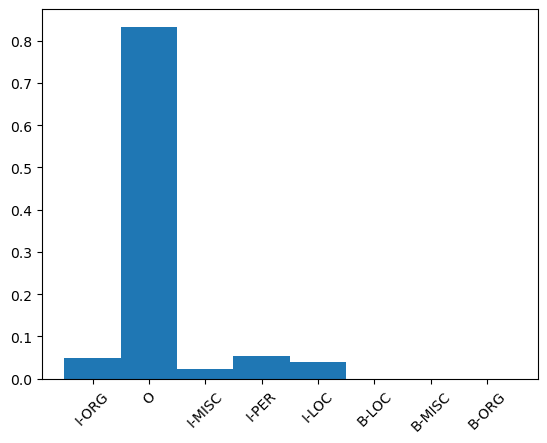

In [17]:
_ = plt.hist([y_enc.get_symbol(y) for y_seq in y_train for y in y_seq], bins=range(len(y_enc)+1), align='left', density=True)
_ = plt.xticks(rotation=45)

So let us have a look at the distribution of tags ignoring the `O` tag.
Now, we have another issue because the `B-<type>` tags are also very rare when compared to the `I-<type>` tags.

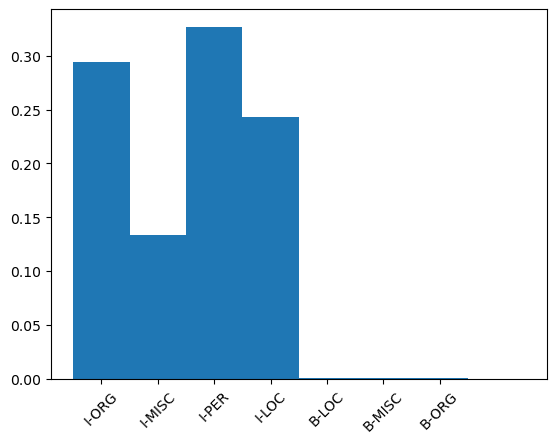

In [18]:
_ = plt.hist([y_enc.get_symbol(y) for y_seq in y_train for y in y_seq if y != y_enc.get_id('O')], bins=range(len(y_enc)+1), align='left', density=True)
_ = plt.xticks(rotation=45)

In [19]:
from collections import Counter

counter = Counter([y_enc.get_symbol(y) for y_seq in y_train for y in y_seq])
total = sum(counter.values())
print({tag: count/total for tag, count in counter.items()})

{'I-ORG': 0.04911575918004528, 'O': 0.832811939829389, 'I-MISC': 0.02237490239218941, 'I-PER': 0.05465055176037835, 'I-LOC': 0.040693248731712345, 'B-LOC': 5.402193290475933e-05, 'B-MISC': 0.0001817101379523723, 'B-ORG': 0.00011786603542856582}


## CRF Model Parameters

In the following, we define a class to store three sets of parameters of a CRF model: 
  start tag ($w^{start} \in \mathbb R^N$), 
  tag transition ($w^{trans} \in \mathbb R^{N \times N}$), 
  and observation feature ($w^{obs} \in \mathbb R^{N \times M}$).
Just as in HMM, each observation feature needs to be crossed against all possible tags, 
  because the CRF model needs to learn a parameter for each feature-tag pair.
For instance, if we have a feature `word=that`,
  we need to learn an observation parameter $w^{obs}_{i,\mathtt{word=that}}$ 
  for each tag $i \in \{1,\ldots,N\}$.
That is why we have $N \times M$ observation parameters.

In [20]:
class CrfModel:
    def __init__(self, num_states, num_observations):
        self.num_states = num_states
        self.num_observations = num_observations

        self.w_start = np.zeros((num_states))
        self.w_trans = np.zeros((num_states, num_states))
        self.w_obs = np.zeros((num_states, num_observations))

## Evaluation Script
NER models are usually evaluated using the CoNLL-2003 evaluation metric.
This metric considers [precision, recall and f1-score](https://en.wikipedia.org/wiki/Precision_and_recall).
Additionally, these values are computed with respect to entities instead of individual tokens.
A predicted entity is consired correct only if the exact tokens are correctly identified and classified.

We use the seqeval library to compute the CoNLL metric.
More specifically, we use the `classification_report` function 
  which reports precision, recall, f1-score and support for each entity type plus three averages over the entity types: micro, macro and weigthed.
In the following, you can see an example of this classification report.
The most important value in this table is the micro-averaged f1-score (`0.55` in the example).

```
              precision    recall  f1-score   support

         LOC       0.84      0.78      0.81      1837
        MISC       0.74      0.70      0.72       922
         ORG       0.21      0.76      0.32      1341
         PER       0.69      0.54      0.60      1842

   micro avg       0.45      0.69      0.55      5942
   macro avg       0.62      0.70      0.61      5942
weighted avg       0.63      0.69      0.62      5942
```

In [21]:
def ids_to_tags(y):
    y_tags = []
    for y_k in y:
        y_tags.append([y_enc.get_symbol(tag) for tag in y_k])
    return y_tags

def decode_y(y, y_pred):
    y = ids_to_tags(y)
    y_pred = ids_to_tags(y_pred)
    return y, y_pred

def cr_eval(xs, ys, crf):
    ys_pred = []
    for x in xs:
        y, _, _ = viterbi_v(x, crf)
        ys_pred.append(np.array(y))

    return classification_report(*decode_y(ys, ys_pred), digits=4)

def f1_score_eval(xs, ys, crf):
    ys_pred = []
    for x in xs:
        y, _, _ = viterbi_v(x, crf)
        ys_pred.append(np.array(y))

    return f1_score(*decode_y(ys, ys_pred))

## Viterbi Algorithm

We now implement the Viterbi algorithm for a CRF model.
It is basically the same algorithm used for an HMM, 
  except that the observation score for each token is computed from a list of features instead of a unique HMM parameter.
Now that we have a log-linear model, to work in the log domain makes even more sense.

### Observation Score Matrix
One key advantage of the CRF model (when compared to HMM) is the possibility to define arbitrary features for each token $x_t$.
But, in order to run the Viterbi algorithm,
  we have that each token has a observation *score* that is equal to the sum of the scores of all its features (one score per possible tag $y_t$).
Thus, after summing the parameters for all features of a token for each tag, 
  we end up with one number per tag for each token.
And this is basically the same as the HMM.
The function below does exactly that:
  it computes the observation score matrix $w^{x,obs} = (w^{x,obs}_{ti})_{t=1,\ldots,T \times i=1,\ldots,N} \in \mathbb R^{T \times N}$,
  where $w^{x,obs}_{ti} \in \mathbb R$ is the score associated with the $t$-th token and the tag $i$.
For each tag $i$, this score is just the sum of the observation parameters for all features of token $x_t$.

In [22]:
def calc_x_w_obs(x, crf):
    x_w_obs = np.zeros((len(x), crf.num_states))
    for t, ftrs in enumerate(x):
        x_w_obs[t] += crf.w_obs[:, ftrs].sum(axis=1)
    return x_w_obs

### Code

In [23]:
def viterbi_v(x, crf):
    #
    # x_w_obs.shape: (seq_len, num_states)
    #   contains the logits for each (token, tag)
    #

    num_states = crf.num_states
    seq_len = len(x)

    x_w_obs = calc_x_w_obs(x, crf)
    
    log_delta = np.zeros((seq_len, num_states))
    psi = np.full((seq_len, num_states), -1, dtype=np.int32)

    # initilization
    log_delta[0] = crf.w_start + x_w_obs[0]

    for t in range(1, seq_len):
        # Sum log_delta[t-1] (array of log_delta in the previous step) with 
        # w_trans matrix. Since delta[t-1] is an array, we want to broadcast its 
        # second dimension through the first dimension of w_trans (which 
        # represents the i state on a transition i->j). So that, in the end, 
        # we have log_delta_a[i,j] = log_delta[t-1,i] + w_trans[i,j]
        log_delta_a = log_delta[t-1].reshape(-1, 1) + crf.w_trans
        
        # log_delta is the max value plus the emission probability on 
        # time-step t. The max is taken along the first dimension, i.e., the max 
        # along the previous state `i` for each state `j`.
        log_delta[t] = log_delta_a.max(axis=0) + x_w_obs[t]

        # psi is the argmax
        psi[t] = log_delta_a.argmax(axis=0)
    
    # now we recover the most likely sequence of states backwards, from the last
    # time step (in Python, -1 represents the last index of a list/array) up to
    # the first one.
    y = []
    # here we use the argmax() method of a numpy array to find the best 
    # state on the last time step
    y.append(log_delta[-1].argmax())
    for t in range(seq_len-1, 0, -1):
        y.append(psi[t, y[-1]])

    # the list y is backwards, so reverse it and return
    y.reverse()
    return y, log_delta, psi

## Structured Perceptron

The following implementation includes an optional argument (`crf_avg`) that, when provided, keeps track of the average (in fact, the sum; but it is the same in practice) model among the models after each iteration.
This version of the perceptron is known as **averaged perceptron** and presents better convergence than the original algorithm.

In [24]:
# algorithm deviates from description in Altun et al. etc., compare with correction below

from numpy.random import default_rng
rng = default_rng()

def struct_perceptron(x_train, y_train, max_iter, crf, crf_avg=None,
                      x_dev=None, y_dev=None, 
                      train_errors=None, dev_f1_scores=None):
    if train_errors is None:
        train_errors = []
    if dev_f1_scores is None:
        dev_f1_scores = []
    
    tbar = tqdm(range(max_iter))
    for iter in tbar:
        # it is usually beneficial to randomize the order we visit the examples
        rnd_idxs = rng.permutation(len(x_train))
        errors = 0
        num_tokens = 0
        for i in rnd_idxs:
            # pick an example
            x, y = x_train[i], y_train[i]
            
            # predict the highest scoring sequence
            y_pred, _, _ = viterbi_v(x, crf)

            # update features for the first time step
            if y_pred[0] != y[0]:
                # correct features
                crf.w_start[y[0]] += 1
                crf.w_obs[y[0], x[0]] += 1
                # incorrect features
                crf.w_start[y_pred[0]] -= 1
                crf.w_obs[y_pred[0], x[0]] -= 1
                
                errors += 1
            
            # update feature weights for the remaining time steps
            num_tokens += 1
            for t in range(1, len(x)):
                if y_pred[t] != y[t]:
                    # correct features
                    crf.w_trans[y[t-1], y[t]] += 1
                    crf.w_obs[y[t], x[t]] += 1
                    # incorrect features
                    crf.w_trans[y_pred[t-1], y_pred[t]] -= 1
                    crf.w_obs[y_pred[t], x[t]] -= 1
                    
                    errors += 1
                
                num_tokens += 1

            # update sum of weights (averaged perceptron)
            if crf_avg is not None:
                crf_avg.w_start += crf.w_start
                crf_avg.w_trans += crf.w_trans
                crf_avg.w_obs += crf.w_obs
        
        # evaluate the averaged model in the DEV dataset
        if x_dev is not None:
            dev_f1_score = f1_score_eval(x_dev, y_dev, crf_avg if crf_avg is not None else crf)
        else:
            dev_f1_score = np.nan

        # compute the ratio of wrongly classified training tokens
        train_error = errors/num_tokens

        train_errors.append(train_error)
        dev_f1_scores.append(dev_f1_score)
        
        tbar.set_description(f'Train errors: {train_error}, DEV F1-score: {dev_f1_score}')

    return train_errors, dev_f1_scores

In [25]:
# Correction: updates now with respect to whether total sequence prediction is right/wrong (as in Altun et.)
# affects only updates to crf.w_trans for individually correct labels ...

from numpy.random import default_rng
rng = default_rng()

def struct_perceptron(x_train, y_train, max_iter, crf, crf_avg=None,
                      x_dev=None, y_dev=None, 
                      train_errors=None, dev_f1_scores=None):
    if train_errors is None:
        train_errors = []
    if dev_f1_scores is None:
        dev_f1_scores = []
    
    tbar = tqdm(range(max_iter))
    for iter in tbar:
        # it is usually beneficial to randomize the order we visit the examples
        rnd_idxs = rng.permutation(len(x_train))
        errors = 0
        num_examples = 0
        for i in rnd_idxs:
            # pick an example
            x, y = x_train[i], y_train[i]
            num_examples += 1
            
            # predict the highest scoring sequence
            y_pred, _, _ = viterbi_v(x, crf)

            if y_pred != y:
                errors += 1

            # update features for the first time step
                # correct features
                crf.w_start[y[0]] += 1
                crf.w_obs[y[0], x[0]] += 1
                # incorrect features
                crf.w_start[y_pred[0]] -= 1
                crf.w_obs[y_pred[0], x[0]] -= 1
            
                # update feature weights for the remaining time steps
                for t in range(1, len(x)):
                    # correct features
                    crf.w_trans[y[t-1], y[t]] += 1  # will happen even if y_pred[t] == y[t]
                    crf.w_obs[y[t], x[t]] += 1
                    # incorrect features
                    crf.w_trans[y_pred[t-1], y_pred[t]] -= 1  # will happen even if y_pred[t] == y[t]
                    crf.w_obs[y_pred[t], x[t]] -= 1
                    
            # update sum of weights (averaged perceptron)
            if crf_avg is not None:
                crf_avg.w_start += crf.w_start
                crf_avg.w_trans += crf.w_trans
                crf_avg.w_obs += crf.w_obs
        
        # evaluate the averaged model in the DEV dataset
        if x_dev is not None:
            dev_f1_score = f1_score_eval(x_dev, y_dev, crf_avg if crf_avg is not None else crf)
        else:
            dev_f1_score = np.nan

        # compute the ratio of wrongly classified training tokens
        train_error = errors/num_examples

        train_errors.append(train_error)
        dev_f1_scores.append(dev_f1_score)
        
        tbar.set_description(f'Train errors: {train_error}, DEV F1-score: {dev_f1_score}')

    return train_errors, dev_f1_scores

## Models
We create two models (`crf` and `crf_avg`) in order to keep track of the average model, which is better than just the final model.

In [26]:
crf = CrfModel(len(y_enc), len(x_enc))
crf_avg = CrfModel(len(y_enc), len(x_enc))
train_errors = []
dev_f1_scores = []

## Training

In [27]:
train_errors, dev_f1_scores = \
    struct_perceptron(x_train=x_train, y_train=y_train, max_iter=10, 
                      crf=crf, crf_avg=crf_avg, x_dev=x_dev, y_dev=y_dev, 
                      train_errors=train_errors, dev_f1_scores=dev_f1_scores)

  0%|          | 0/10 [00:00<?, ?it/s]

## Results

In [ ]:
plt.plot(train_errors)

In [ ]:
plt.plot(dev_f1_scores)

In [ ]:
print(cr_eval(x_dev, y_dev, crf_avg))